# Notebook options

In [1]:
%matplotlib inline
# This is included in the article
remove_gender_input = False
# Optimizing parameters results in higher gener performance differences
grid_search = False 

**Debate**:
* Por qué aumenta la discriminación al optimizar los hiperparámetros
* ¿Cómo podríamos reducirla a nivel de crossvalidación?
* ¿Qué sentido puede tener meter el sexo dentro de las variables independientes?

**Discussion**:
* Why unfairness increases when optimising hyperparameters?
* How could we reduce it at the cross-validation level?
* Why does it make sense to include gender as an independent variable?

# Exploratory analysis of the dataset

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

columns = ['Age', 'Gender', 'Total_Bilirubin',
           'Direct_Bilirubin','Alkphos_Alkaline_Phosphotase', 
           'Sgpt_Alamine_Aminotransferase', 'Sgot_Aspartate_Aminotransferase', 
           'TP_Total_Protiens', 'ALB_Albumin', 'Albumin_and_Globulin_Ratio', 
           'Liver_Disease']


columns_short = ['Age', 'Gender', 'TB',
           'DB','AAP', 
           'Sgpt', 'Sgot', 
           'TP', 'Albumin', 'AG_Ratio', 
           'Liver_Disease']

# Liver_Disease = 1 (disease), 2 (no disease)

df = pd.read_csv('data/IndianLiverPatientDataset-ILPD.csv', 
                 header=None, names=columns_short)


# Check for nan and clean nan
print(df.isnull().values.any())
print(df.isnull().sum().sum())
df.dropna(inplace=True)


True
4


Female         AxesSubplot(0.1,0.15;0.363636x0.75)
Male      AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

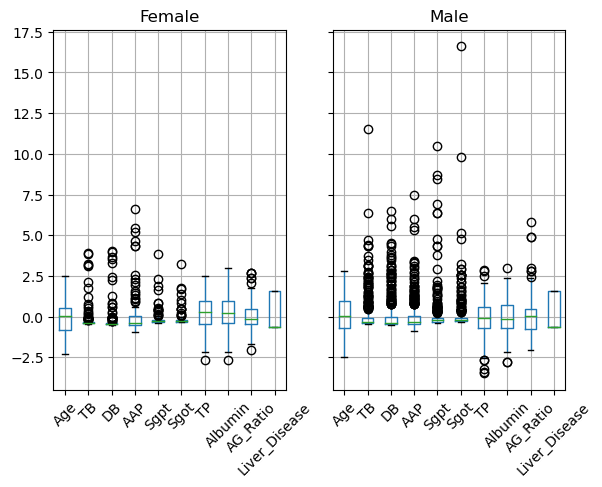

In [3]:
def z_score_standardization(series):
    return (series - series.mean()) / series.std()

df_s = df.copy()
for col in df_s.columns:
    if col != 'Gender':
        df_s[col] = z_score_standardization(df_s[col])
    
#df_s.groupby('Gender').boxplot(rot=45,figsize = (8,4))
df_s.groupby('Gender').boxplot(rot=45)

<AxesSubplot:>

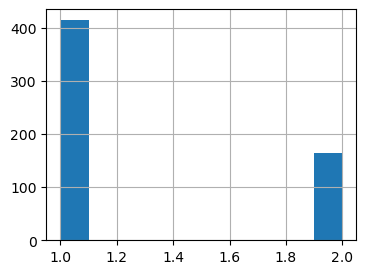

In [4]:
df['Liver_Disease'].hist(figsize = (4,3))

In [5]:
print(df.groupby(['Liver_Disease']).size())

Liver_Disease
1    414
2    165
dtype: int64


array([<AxesSubplot:title={'center':'Female'}>,
       <AxesSubplot:title={'center':'Male'}>], dtype=object)

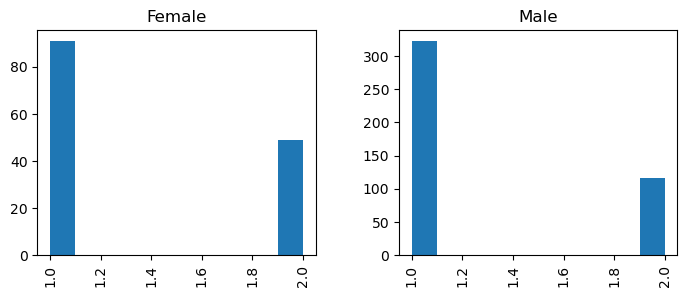

In [6]:
df['Liver_Disease'].hist(by=df['Gender'], figsize = (8,3))

# Create,  preprocess and split dataset        

In [7]:
# TODO: Alternative code with Pipeline
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np


# New column with binary values for groups
# 0 - Men
# 1 - Women
df['Gender_bin'] = 0
df.loc[df["Gender"] == "Female", "Gender_bin"] = 1
df['Gender_bin']

dataset_X = df.drop(columns=['Gender', 'Liver_Disease']).to_numpy()
dataset_y = df['Liver_Disease'].to_numpy()

# Target (disease=1)
dataset_y[dataset_y == 2] = 0

# y_train = 1 Disease (positive)
# y_train = 0 No Disease (negative)
X_train, X_test, y_train, y_test = train_test_split(
    dataset_X, dataset_y, test_size=0.30)

gender_bin_train = X_train[:,-1]
gender_bin_test = X_test[:,-1]

# Remove gender from input **after** random spliting
if (remove_gender_input):
    X_train = X_train[:,:-1]
    X_test = X_train[:,:-1]

train_y_onehot = np.concatenate([y_train])

In [8]:
# max_min scaler is used in Straw & Wu 2022
# however it causes LR to fail to converge. 
#scaler = preprocessing.MinMaxScaler().fit(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Fit and evaluate models

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

if grid_search:
    lr_params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "solver": ["liblinear"]}
    lr = LogisticRegression()
    clf = GridSearchCV(lr, lr_params, cv=5, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on training set:")
    print(clf.best_params_)

    lr = LogisticRegression(C=clf.best_params_['C'], penalty=clf.best_params_['penalty']
    , solver=clf.best_params_['solver']
    )
else:
    lr = LogisticRegression(solver='liblinear')


lr.fit(X_train_scaled, y_train)
y_test_pred = lr.predict(X_test_scaled)
y_test_scores = lr.decision_function(X_test_scaled)


### ROC Comparison

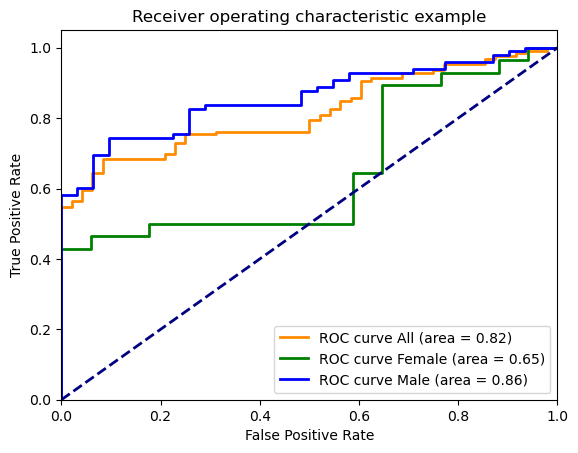

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_groups(y_test, y_test_scores, gender_bin_test):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test[:], y_test_scores[:])
    roc_auc = auc(fpr, tpr)

    # Compute ROC curve and ROC area for each class
    fpr_w, tpr_w, _ = roc_curve(y_test[(gender_bin_test==1)], y_test_scores[(gender_bin_test==1)])
    roc_auc_w = auc(fpr_w, tpr_w)

    fpr_m, tpr_m, _ = roc_curve(y_test[(gender_bin_test==0)], y_test_scores[(gender_bin_test==0)])
    roc_auc_m = auc(fpr_m, tpr_m)

    plt.figure()
    lw = 2
    plt.plot(fpr,tpr,color="darkorange",lw=lw,
        label="ROC curve All (area = %0.2f)" % roc_auc)

    plt.plot(fpr_w,tpr_w,color="green",lw=lw,
        label="ROC curve Female (area = %0.2f)" % roc_auc_w)

    plt.plot(fpr_m,tpr_m,color="blue",lw=lw,
        label="ROC curve Male (area = %0.2f)" % roc_auc_m)

    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc_groups(y_test, y_test_scores, gender_bin_test)
plt.show()

### Fairlearn metrics

In [11]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import false_negative_rate
from fairlearn.metrics import false_positive_rate

#group_membership_data = df['Gender'].to_list()
group_membership_data = gender_bin_test


print(len(group_membership_data))
print(len(y_test_pred))

grouped_metric = MetricFrame(metrics=false_negative_rate,
                             y_true=y_test,
                             y_pred=y_test_pred,
                             sensitive_features=group_membership_data)

print("FN Rate: = ", grouped_metric.overall)
print("FN Rate by groups = ", grouped_metric.by_group.to_dict())


grouped_metric = MetricFrame(metrics=false_positive_rate,
                             y_true=y_test,
                             y_pred=y_test_pred,
                             sensitive_features=group_membership_data)

print("FP Rate: = ", grouped_metric.overall)
print("FP Rate by groups = ", grouped_metric.by_group.to_dict())



174
174
FN Rate: =  0.031746031746031744
FN Rate by groups =  {0.0: 0.02040816326530612, 1.0: 0.07142857142857142}
FP Rate: =  0.8541666666666666
FP Rate by groups =  {0.0: 0.8709677419354839, 1.0: 0.8235294117647058}


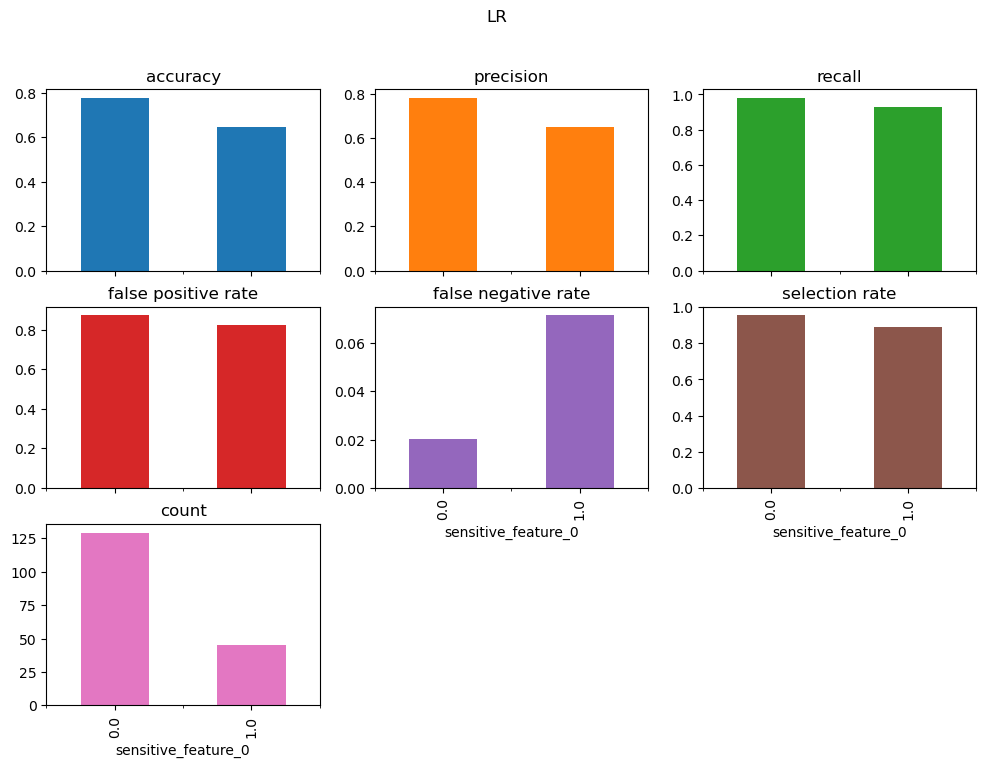

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from fairlearn.metrics import false_positive_rate
from fairlearn.metrics import true_positive_rate
from fairlearn.metrics import selection_rate
from fairlearn.metrics import count

metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false positive rate': false_positive_rate,
    'false negative rate': false_negative_rate,
    'selection rate': selection_rate,
    'count': count}
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_test,
                           y_pred=y_test_pred,
                           sensitive_features=group_membership_data)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="LR",
)
plt.show()